# **Illegal Tap Water Detection Using Pipeline Sensor Data**
To build a machine learning model that detects water theft through illegal pipeline taps.

# Overview of Dataset
This section gives a brief overview of the dataset, including its columns and data types.

In [1]:
import pandas as pd

df = pd.read_csv("pipeline_sensor_data.csv")
df.head()

,Time,SensorID,pressure,flow_rate,leak_intensity,illegal_tap_flag,event_type
0,1:00 PM,S001,2.82,123.91,0.0,0,normal
1,1:10 PM,S001,2.71,113.40,0.0,0,normal
2,1:20 PM,S001,2.84,121.48,0.0,0,normal
3,1:30 PM,S001,2.82,121.73,0.0,0,normal
4,1:40 PM,S001,2.75,121.16,0.0,0,normal


# Handling Categorical Variables: Columns like “SensorID”, “Time” and "event_type" need to be encoded numerically
Loads the sensor dataset, identifies categorical columns (`SensorID`, `Time`, and `event_type`), and encodes them into numeric values using pandas’ built-in category codes. The encoded data is then saved as a new CSV file (`encoded_pipeline_sensor_data.csv`) for further processing or machine learning.

* normal - 5
* low_leak - 3
* blockage - 0
* leak_high - 2
* irregular_flow - 1
* negative_pressure - 4

In [3]:
df = pd.read_csv('pipeline_sensor_data.csv')
print(df.dtypes)

df['SensorID_encoded'] = df['SensorID'].astype('category').cat.codes
print(df[['SensorID', 'SensorID_encoded']].head())

df['event_type_encoded'] = df['event_type'].astype('category').cat.codes
print(df[['event_type', 'event_type_encoded']].head())

df['Time_encoded'] = df['Time'].astype('category').cat.codes
print(df[['Time', 'Time_encoded']].head())

df.to_csv('encoded_pipeline_sensor_data.csv', index=False)
df.head()

Time                 object
SensorID             object
pressure            float64
flow_rate           float64
leak_intensity      float64
illegal_tap_flag      int64
event_type           object
dtype: object
  SensorID  SensorID_encoded
0     S001                 0
1     S001                 0
2     S001                 0
3     S001                 0
4     S001                 0
  event_type  event_type_encoded
0     normal                   5
1     normal                   5
2     normal                   5
3     normal                   5
4     normal                   5
      Time  Time_encoded
0  1:00 PM             0
1  1:10 PM             1
2  1:20 PM             2
3  1:30 PM             3
4  1:40 PM             4


,Time,SensorID,pressure,flow_rate,leak_intensity,illegal_tap_flag,event_type,SensorID_encoded,event_type_encoded,Time_encoded
0,1:00 PM,S001,2.82,123.91,0.0,0,normal,0,5,0
1,1:10 PM,S001,2.71,113.40,0.0,0,normal,0,5,1
2,1:20 PM,S001,2.84,121.48,0.0,0,normal,0,5,2
3,1:30 PM,S001,2.82,121.73,0.0,0,normal,0,5,3
4,1:40 PM,S001,2.75,121.16,0.0,0,normal,0,5,4


# Splitting Dataset by Sensor Segments for Train and Test
The dataset is split into training and testing sets based on sensor arguements. We are randomly choosing 80% of them for training and 20% for testing. This helps make sure the model is tested on new sensors it hasn’t seen before.

In [9]:
from sklearn.model_selection import train_test_split

# Load encoded dataset
df = pd.read_csv('encoded_pipeline_sensor_data.csv')

# Get unique sensors and split (80% train, 20% test)
unique_segments = df['SensorID'].unique()
train_segments, test_segments = train_test_split(unique_segments, test_size=0.2, random_state=42)

# Create initial train and test DataFrames
train_df = df[df['SensorID'].isin(train_segments)]
test_df = df[df['SensorID'].isin(test_segments)]

# Display initial split info
print(f'Initial Train segments: {len(train_segments)}, data points: {len(train_df)}')
print(f'Initial Test segments: {len(test_segments)}, data points: {len(test_df)}')
print('Initial Train class distribution:')
print(train_df['event_type_encoded'].value_counts(normalize=True).sort_index())
print('Initial Test class distribution:')
print(test_df['event_type_encoded'].value_counts(normalize=True).sort_index())

# Class balancing: Move 70 'blockage' samples from test to train
test_blockage = test_df[test_df['event_type'] == 'blockage']
if len(test_blockage) >= 70:
    blockage_sample = test_blockage.sample(n=70, random_state=42)
    test_df = test_df.drop(blockage_sample.index)
    train_df = pd.concat([train_df, blockage_sample])
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
else:
    print("Warning: Not enough 'blockage' samples in test set to move 70.")

# Display updated split info
print(f'Updated Train segments: {len(train_segments)}, data points: {len(train_df)}')
print(f'Updated Test segments: {len(test_segments)}, data points: {len(test_df)}')
print('Updated Train class distribution:')
print(train_df['event_type_encoded'].value_counts(normalize=True).sort_index())
print('Updated Test class distribution:')
print(test_df['event_type_encoded'].value_counts(normalize=True).sort_index())

print("\n")
event_mapping = {0: 'blockage', 1: 'irregular_flow', 2: 'leak_high', 3: 'leak_low', 4: 'negative_pressure', 5: 'normal'}
print('Train class distribution (with names):')
counts = train_df['event_type_encoded'].value_counts().sort_index()
for enc, count in counts.items():
    print(f"{event_mapping[enc]}: {count} ({count / len(train_df) * 100:.2f}%)")

print("\n")
event_mapping = {0: 'blockage', 1: 'irregular_flow', 2: 'leak_high', 3: 'leak_low', 4: 'negative_pressure', 5: 'normal'}
print('Test class distribution (with names):')
counts = test_df['event_type_encoded'].value_counts().sort_index()
for enc, count in counts.items():
    print(f"{event_mapping[enc]}: {count} ({count / len(train_df) * 100:.2f}%)")

# Save updated splits
train_df.to_csv('__train.csv', index=False)
test_df.to_csv('__test.csv', index=False)

Initial Train segments: 160, data points: 8000
Initial Test segments: 40, data points: 2000
Initial Train class distribution:
event_type_encoded
1    0.012125
2    0.017250
3    0.008250
4    0.006125
5    0.956250
Name: proportion, dtype: float64
Initial Test class distribution:
event_type_encoded
0    0.1420
1    0.1820
2    0.1095
3    0.0995
4    0.0230
5    0.4440
Name: proportion, dtype: float64
Updated Train segments: 160, data points: 8070
Updated Test segments: 40, data points: 1930
Updated Train class distribution:
event_type_encoded
0    0.008674
1    0.012020
2    0.017100
3    0.008178
4    0.006072
5    0.947955
Name: proportion, dtype: float64
Updated Test class distribution:
event_type_encoded
0    0.110881
1    0.188601
2    0.113472
3    0.103109
4    0.023834
5    0.460104
Name: proportion, dtype: float64


Train class distribution (with names):
blockage: 70 (0.87%)
irregular_flow: 97 (1.20%)
leak_high: 138 (1.71%)
leak_low: 66 (0.82%)
negative_pressure: 49 (0.61%)
n

We observe that most samples belong to the “normal” class, which is expected because in real-world conditions, occurrences of leaks or illegal taps are relatively rare compared to normal sensor readings.

# Past-based features
We make new features from the past readings of each sensor. Instead of looking at just the current pressure and flow rate, we also add information about how these values changed over time.

Here we transform the raw data into a rich time-aware dataset by adding many new columns.

* We sort by `SensorID_encoded` and `Time_encoded`, then group by each sensor. This ensures every sensor’s readings are processed in chronological order.
* For each signal (`pressure`, `flow_rate`), we create lagged versions. This helps the model compare “now” vs. “then”. If pressure ***suddenly drops*** compared to the last reading, it might signal a leak or illegal tap!
  - `pressure_lag1`: Pressure 1 time step ago
  - `pressure_lag5`: Pressure 5 steps ago
  - (and so on)
* Add change features (spotting differences). This captures how sharply things change. A sudden 50% flow drop could mean an illegal tap or burst pipe!!
  - Delta: `pressure_delta1` = change from last reading
  - Percent change: `pressure_pct1` = relative change percentage
* We calculate the mean, std, min, max, median for past readings over rolling windows of 5, 10, and 20 time steps. This filters out random spikes. Steady drops or increases reveal long-term issues like blockages or leaks.
  - `pressure_roll5_mean` → average pressure in last 5 readings
  - `flow_rate_roll10_std` → variation in flow over last 10 readings
* We use the custom slope function to find how fast readings are rising or falling over time. Slope reveals acceleration, how quickly things are getting worse. For example, a leak spreading.
  - `pressure_roll10_slope` → speed of pressure change
  - `flow_rate_roll20_slope` → long-term flow trend
* Interaction feature. This links both signals. High flow with low pressure often hints at illegal diversions or leaks.
  - `ratio_flow_pressure` = flow rate / pressure (from the last time step)

### Why is this very important??

Without these engineered features, the model only sees a snapshot — like one frame of a movie.
With them, it sees the entire story of each sensor’s behavior.

- A rising **pressure slope** + falling **flow rate** → possible blockage.
- A sudden **flow drop** + stable pressure → potential illegal tap.
- Gradual **decline in both** → developing leak.

These past-based features give the model memory, helping it spot early warning signs and rare anomalies more accurately.
    

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [40]:
import numpy as np
import pandas as pd

# Constants for feature engineering
ID_COL = 'SensorID_encoded'
TIME_COL = 'Time_encoded'
SIG_COLS = ['pressure', 'flow_rate']
LAGS = [1, 3, 5, 10]
ROLL_WINDOWS = [5, 10, 20]
EPS = 1e-6

def rolling_slope_past_only(values: np.ndarray, window: int) -> np.ndarray:
    """Calculate rolling slope for past values only."""
    n = len(values)
    out = np.full(n, np.nan)
    t = np.arange(window, dtype=float)
    t_mean = t.mean()
    var_t = ((t - t_mean) ** 2).sum()
    if var_t == 0:
        return out
    for i in range(window - 1, n):
        w = values[i - window + 1 : i + 1]
        if np.isnan(w).any():
            continue
        x_mean = w.mean()
        cov_tx = ((t - t_mean) * (w - x_mean)).sum()
        out[i] = cov_tx / var_t
    return out

def add_past_only_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add lag, delta, rolling, and interaction features."""
    df = df.sort_values([ID_COL, TIME_COL]).copy()
    g = df.groupby(ID_COL, group_keys=False)
    
    # Lags
    for s in SIG_COLS:
        for L in LAGS:
            df[f'{s}_lag{L}'] = g[s].shift(L)
    
    # Delta and percent change
    for s in SIG_COLS:
        df[f'{s}_delta1'] = df[s] - df[f'{s}_lag1']
        df[f'{s}_pct1'] = df[f'{s}_delta1'] / (np.abs(df[f'{s}_lag1']) + EPS)
    
    # Rolling stats (past-only)
    for s in SIG_COLS:
        s_past = g[s].shift(1)
        for w in ROLL_WINDOWS:
            roll = s_past.groupby(df[ID_COL]).rolling(window=w, min_periods=w)
            df[f'{s}_roll{w}_mean'] = roll.mean().reset_index(level=0, drop=True)
            df[f'{s}_roll{w}_std'] = roll.std().reset_index(level=0, drop=True)
            df[f'{s}_roll{w}_min'] = roll.min().reset_index(level=0, drop=True)
            df[f'{s}_roll{w}_max'] = roll.max().reset_index(level=0, drop=True)
            df[f'{s}_roll{w}_med'] = roll.median().reset_index(level=0, drop=True)
    
    # Rolling slopes
    for s in SIG_COLS:
        s_past = g[s].shift(1)
        arr = s_past.to_numpy()
        for w in ROLL_WINDOWS:
            col = f'{s}_roll{w}_slope'
            df[col] = np.nan
            for _, idx in g.indices.items():
                idx = np.array(idx)
                sl = rolling_slope_past_only(arr[idx], w)
                df.loc[idx, col] = sl
    
    # Interaction feature
    df['ratio_flow_pressure'] = df['flow_rate_lag1'] / (np.abs(df['pressure_lag1']) + EPS)
    
    return df

# Apply feature engineering to full dataset
df_feat = add_past_only_features(df)

# Drop rows with insufficient history
df_feat = df_feat.dropna().reset_index(drop=True)

# Save the full engineered dataset
print(df_feat.head())
df_feat.to_csv('engineered_features.csv', index=False)

# Define features and target
FEATURE_COLS = (
    ['pressure', 'flow_rate', 'leak_intensity', 'illegal_tap_flag', 'SensorID_encoded', 'ratio_flow_pressure'] +
    [f'pressure_lag{k}' for k in LAGS] + [f'flow_rate_lag{k}' for k in LAGS] +
    ['pressure_delta1', 'pressure_pct1', 'flow_rate_delta1', 'flow_rate_pct1'] +
    ['pressure_roll5_mean', 'pressure_roll10_std', 'pressure_roll20_min',
     'flow_rate_roll5_mean', 'flow_rate_roll10_std', 'flow_rate_roll20_min',
     'pressure_roll5_slope', 'pressure_roll10_slope', 'pressure_roll20_slope',
     'flow_rate_roll5_slope', 'flow_rate_roll10_slope', 'flow_rate_roll20_slope']
)

# Split into train/test using time-aware mask (75% train per sensor)
df_feat_sorted = df_feat.sort_values([ID_COL, TIME_COL]).reset_index(drop=True)
mask = df_feat_sorted.groupby(ID_COL, group_keys=False).apply(
    lambda g: pd.Series([True] * int(len(g) * 0.75) + [False] * (len(g) - int(len(g) * 0.75)), index=g.index)
)

X_all = df_feat_sorted[FEATURE_COLS]
y_all = df_feat_sorted['event_type_encoded']
X_train = X_all[mask.values]
X_test = X_all[~mask.values]
y_train = y_all[mask.values]
y_test = y_all[~mask.values]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Save the split data (features and targets) for reuse
X_train.to_csv('X_train_features.csv', index=False)
X_test.to_csv('X_test_features.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train_target.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test_target.csv', index=False)

# Save as pickle for faster loading (preserves data types)
# import pickle
# with open('X_train.pkl', 'wb') as f: pickle.dump(X_train, f)
# with open('X_test.pkl', 'wb') as f: pickle.dump(X_test, f)
# with open('y_train.pkl', 'wb') as f: pickle.dump(y_train, f)
# with open('y_test.pkl', 'wb') as f: pickle.dump(y_test, f)

      Time SensorID  pressure  flow_rate  leak_intensity  illegal_tap_flag  \
0  4:20 PM     S001      2.78     123.57             0.0                 0   
1  4:30 PM     S001      2.83     119.64             0.0                 0   
2  4:40 PM     S001      2.74     112.43             0.0                 0   
3  4:50 PM     S001      2.77     124.28             0.0                 0   
4  5:00 PM     S001      2.81     113.77             0.0                 0   

  event_type  SensorID_encoded  event_type_encoded  Time_encoded  ...  \
0     normal                 0                   5            20  ...   
1     normal                 0                   5            21  ...   
2     normal                 0                   5            22  ...   
3     normal                 0                   5            23  ...   
4     normal                 0                   5            24  ...   

   flow_rate_roll20_min  flow_rate_roll20_max  flow_rate_roll20_med  \
0                113.

# Training the model
We train an XGBoost model to predict the type of pipeline event (for example, normal flow, leakage, or illegal tap) using the sensor data. We read the pre-split training and testing datasets and then use key sensor readings (`pressure`, `flow_rate`, `leak_intensity`, etc.) to predict the column `event_type_encoded`. We also handle class imbalance by giving rare classes more importance during training. The classification report (precision, recall, F1-score). The confusion matrix, which shows how often each class was confused with others. Finally, we map the numeric predictions back to their original event type names to make the results easier to understand.

This gives us a clear view of how well the model can detect different types of pipeline events from the sensor data.

In [13]:
train = pd.read_csv('__train.csv')
test = pd.read_csv('__test.csv')

print("TRAIN:\n", train['event_type'].value_counts())
print("\nTEST:\n", test['event_type'].value_counts())

TRAIN:
 event_type
normal               7650
leak_high             138
irregular_flow         97
blockage               70
leak_low               66
negative_pressure      49
Name: count, dtype: int64

TEST:
 event_type
normal               888
irregular_flow       364
leak_high            219
blockage             214
leak_low             199
negative_pressure     46
Name: count, dtype: int64


In [7]:
# mkaing sure "blockage" is present
test_blockage = test[test['event_type'] == 'blockage']
print(test_blockage)

         Time SensorID  pressure  flow_rate  leak_intensity  illegal_tap_flag  \
129   5:50 PM     S017      7.25       5.07             0.0                 1   
130   6:00 PM     S017      7.32       5.22             0.0                 1   
131   6:10 PM     S017      7.24       6.43             0.0                 1   
132   6:20 PM     S017      7.25       5.04             0.0                 1   
133   6:30 PM     S017      7.18       6.87             0.0                 1   
...       ...      ...       ...        ...             ...               ...   
1795  8:30 PM     S171      7.36       5.17             0.0                 1   
1796  8:40 PM     S171      6.68       6.39             0.0                 1   
1797  8:50 PM     S171      6.98       6.21             0.0                 1   
1798  9:00 PM     S171      6.66       4.83             0.0                 1   
1799  9:10 PM     S171      7.07       5.39             0.0                 1   

     event_type  SensorID_e

In [14]:
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# load train/test splitted csv
train_df = pd.read_csv('__train.csv')
test_df = pd.read_csv('__test.csv')

# defining features and target
feature_cols = ['pressure', 'flow_rate', 'leak_intensity', 'illegal_tap_flag', 'SensorID_encoded', 'Time_encoded']
target_col = 'event_type_encoded'

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# fix label encoding
le = LabelEncoder()
le.fit(list(y_train) + list(y_test))
y_train_clean = le.transform(y_train)
y_test_clean = le.transform(y_test)

# compute sample weights for class imbalance
classes = np.unique(y_train_clean)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_clean)
weight_dict = dict(zip(classes, class_weights))
weights = pd.Series(y_train_clean).map(weight_dict)

# create dmatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train_clean, weight=weights)
dtest = xgb.DMatrix(X_test, label=y_test_clean)

# train xgboost multi-class model
params = {
    'objective': 'multi:softprob',
    'num_class': len(le.classes_),
    'eval_metric': 'mlogloss',
    'seed': 42
}
bst = xgb.train(params, dtrain, num_boost_round=100)

# model evaluation
y_pred_prob = bst.predict(dtest)
y_pred = y_pred_prob.argmax(axis=1)
print("Classification Report:\n")
print(classification_report(y_test_clean, y_pred))
print("\n\nConfusion Matrix:\n")
print(confusion_matrix(y_test_clean, y_pred))

# create mapping from encoded labels to human-readable event types
all_labels = pd.concat([
    train_df[['event_type_encoded', 'event_type']],
    test_df[['event_type_encoded', 'event_type']]
]).drop_duplicates()

mapping = dict(zip(all_labels['event_type_encoded'], all_labels['event_type']))

actual_event_types = [mapping[x] for x in y_test_clean]
predicted_event_types = [mapping[x] for x in y_pred]

print("\n\n")

print("Actual :", actual_event_types[:100])
print("Predicted:", predicted_event_types[:100])

predicted_labels = le.inverse_transform(y_pred)
actual_labels = le.inverse_transform(y_test_clean)

# save model
bst.save_model("xgboost_pipeline_event_model.json")

Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       214
           1       1.00      0.97      0.98       364
           2       1.00      1.00      1.00       219
           3       1.00      1.00      1.00       199
           4       0.96      1.00      0.98        46
           5       1.00      1.00      1.00       888

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



Confusion Matrix:

[[213   1   0   0   0   0]
 [  8 354   0   0   2   0]
 [  0   0 219   0   0   0]
 [  0   0   0 199   0   0]
 [  0   0   0   0  46   0]
 [  0   0   0   0   0 888]]



Actual : ['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'norma

# Visualization of model's performance

### Tabular format
structured like a spreadsheet—easy to see rows, spot mismatches (✗), and compare

In [27]:
from tabulate import tabulate

# Prepare data for table (first 100)
num_samples = 100
table_data = []
for i in range(num_samples):
    actual = actual_event_types[i]
    predicted = predicted_event_types[i]
    match = "✓" if actual == predicted else "✗"  # Simple match indicator
    table_data.append([i+1, actual, predicted, match])

# Print as a table
print("\nActual vs Predicted (First {} Samples):".format(num_samples))
print(tabulate(table_data, headers=["Index", "Actual", "Predicted", "Match"], tablefmt="grid"))


Actual vs Predicted (First 100 Samples):
+---------+-----------+-------------+---------+
|   Index | Actual    | Predicted   | Match   |
+=========+===========+=============+=========+
|       1 | normal    | normal      | ✓       |
+---------+-----------+-------------+---------+
|       2 | normal    | normal      | ✓       |
+---------+-----------+-------------+---------+
|       3 | normal    | normal      | ✓       |
+---------+-----------+-------------+---------+
|       4 | normal    | normal      | ✓       |
+---------+-----------+-------------+---------+
|       5 | normal    | normal      | ✓       |
+---------+-----------+-------------+---------+
|       6 | normal    | normal      | ✓       |
+---------+-----------+-------------+---------+
|       7 | normal    | normal      | ✓       |
+---------+-----------+-------------+---------+
|       8 | normal    | normal      | ✓       |
+---------+-----------+-------------+---------+
|       9 | normal    | normal      | ✓       

### Confusion Matrix
* A confusion matrix heatmap, it shows how often each class (e.g., "normal", "leak_high") was predicted correctly or confused with others.
* It gives a high-level view of model performance.
* We can easily find out where the model struggles.

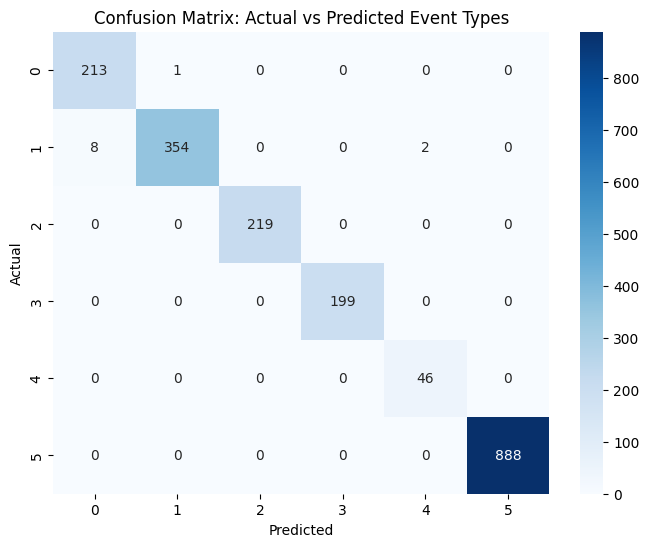

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test_clean, y_pred)

# Plot as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: Actual vs Predicted Event Types')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Mismatches
Prints mismatches and summary stats.

In [33]:
# Calculate mismatches for the ENTIRE test set
mismatches = [(i, actual_event_types[i], predicted_event_types[i]) for i in range(len(actual_event_types)) if actual_event_types[i] != predicted_event_types[i]]

# Print summary for the full test set
total_samples = len(actual_event_types)  # Full test set size
accuracy = (total_samples - len(mismatches)) / total_samples * 100
print(f"\nActual vs Predicted Summary (Full Test Set - {total_samples} Samples):")
print(f"Total Samples: {total_samples}")
print(f"Correct Predictions: {total_samples - len(mismatches)} ({accuracy:.1f}%)")
print(f"Mismatches: {len(mismatches)}")

# Print ALL mismatches in a readable list (but limit display to first 50 for readability)
if mismatches:
    print("\nAll Mismatches (Index, Actual → Predicted):")
    max_display = 50  # Show first 50
    for idx, actual, pred in mismatches[:max_display]:
        print(f"  {idx+1}: {actual} → {pred}")
    if len(mismatches) > max_display:
        print(f"  ... and {len(mismatches) - max_display} more mismatches")
else:
    print("No mismatches in the full test set!")


Actual vs Predicted Summary (Full Test Set - 1930 Samples):
Total Samples: 1930
Correct Predictions: 1919 (99.4%)
Mismatches: 11

All Mismatches (Index, Actual → Predicted):
  569: irregular_flow → blockage
  624: irregular_flow → blockage
  840: blockage → irregular_flow
  1066: irregular_flow → negative_pressure
  1413: irregular_flow → blockage
  1433: irregular_flow → negative_pressure
  1442: irregular_flow → blockage
  1598: irregular_flow → blockage
  1600: irregular_flow → blockage
  1819: irregular_flow → blockage
  1821: irregular_flow → blockage
